In [1]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy
import math

In [2]:
age_class = ["<1", "1-4", "5-9", "10-14", "15-19", "20-29", "30+"]
#Select disease
d = "Rubella"

#monthly data
data = pd.read_csv( d +'_data_processed.csv')
monthly_data = data.iloc[:,1:8]
monthly_data = monthly_data[age_class]

#I do not consider 2019
monthly_data = monthly_data.iloc[0:(data.shape[0]-12),:]

time_date = data["Time"][0:(data.shape[0]-12)]

if d== "Mumps":
    years_run = int(time_date[len(time_date)-1]) - int(time_date[0]) +1
    start_yr = int(time_date[0])
    end_yr = int(time_date[len(time_date)-1])
     
else:
    start_yr = int(time_date[0][0:4])
    end_yr = int(time_date[len(time_date)-1][0:4])
    years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1

print(start_yr)
print(end_yr)
print(years_run, "--> tmax")

2007
2018
12 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [3]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
if d == "Mumps":
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]
else:
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = np.asarray(list(reversed(Births_UK)))/1000 # Normalise to per capita
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018

Deaths_years = Deaths.iloc[:,np.where(Deaths.columns== str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns==str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#print(Pops_tot)

Pops_tot = np.asarray(Pops_tot)

##### Including real contact matrix from Polymod

- equally weighted one

In [4]:
Poly_7_new = pd.read_csv("Data/Poly_7.csv")
Poly_7_new = Poly_7_new.iloc[:,1:8]
Poly_7_new = Poly_7_new.iloc[np.hstack([6, np.arange(0,6)]),:]
C_poly = Poly_7_new.values

#### Vaccine coverage and Vaccinated IC

In [5]:
Cov_rate = pd.read_csv("Data//" +d +'_vaccine_coverage.csv')
V_ic = Cov_rate.iloc[0:7,1:2]
V_ic = V_ic.to_numpy().reshape((7,))/100
Cov_rate_years = Cov_rate.iloc[0:7,2:21]

# Issue: vaccination rate is up until 2016, now assume 2017-19 are the same?
Cov_rate_years["2017"] = Cov_rate_years["2018"]  = Cov_rate_years["2016"]

Cov_rate_years = Cov_rate_years.iloc[:,np.where(Cov_rate_years.columns== str(start_yr))[0][0]:np.where(Cov_rate_years.columns==str(end_yr))[0][0]+1]
Shift_cov_rate_years = Cov_rate_years.iloc[np.hstack([6, np.arange(0,6)]),:]

In [6]:
from multiprocessing import Process, Array

def get_yearly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, n_years, dtype=np.int32)])

def get_monthly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, 12*n_years, dtype=np.int32)])
                       
def f_ssq(beta_vec):
    n_eval=120
    beta = np.eye(7)*np.maximum(beta_vec,0.001)
    mdl = m.SIRVModel(para, lambda t: beta)
    
    ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)    
    
    if d == "Mumps":
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, pop_scale=pop_scale, atol =1e-6, rtol = 1e-3)
        new_inf = get_yearly_rates(out_YN, n_eval, years_run)
    else:
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, pop_scale=pop_scale, atol =1e-6, rtol = 1e-3)
        new_inf = get_monthly_rates(out_YN, n_eval, years_run)
    
    ssq = np.sum(np.sum((new_inf*((1/pop_scale)*1e5)-np.reshape(monthly_data[age_class].to_numpy()[0:-1], (7,-1)))**2))
    print("Loss: "+str(ssq)+" Beta: "+str(beta_vec))
    return ssq

def f_ssq_wrapper(beta_vec, ret):
    ret[0] = f_ssq(beta_vec)

def f_ssq_timeout(beta_vec):
    val = Array('d',1)
    p = Process(target=f_ssq_wrapper, args = (beta_vec,val,))
    p.start()
    p.join(20)
    if p.is_alive():
        print("Maximum computation time exceeded")
        p.terminate()
        p.join()
        return 1e100
    else:
        return val[0]

Each age group IC is weighted by their percetange at first year pop

In [7]:
def estimate_SIR_IC(mdl, age_struct, pop_scale, V_ic, eps_I = 1e-6, k=7):
    ###Start with a population where anyone who isnt vaccinated is susceptible 
    #(+eps_I level of infections))
    S_ic = (np.ones(k)-V_ic)*(1-eps_I)
    I_ic = (np.ones(k)-V_ic-S_ic)*[1,1,1,1,1,1,1]
    R_ic = (np.ones(k) - S_ic - I_ic - V_ic)
    
    #Normalise profile
    norm_ic = np.hstack([S_ic*age_struct_start,  
                    I_ic*age_struct_start,
                    R_ic*age_struct_start,
                    V_ic*age_struct_start])*pop_scale
    
    ### Run for a year
    out, t, out_YN = mdl.run(norm_ic, 
                             t_max = 1.0,
                             method="RK45",
                             eval_per_year=120,
                             pop_scale=pop_scale, atol=1e-3, rtol=1e-4)
    
    ### Note this only works for sensible betas and gammas 
    ###(i.e. assumes epidemic over in a year)
    level_estimate = out[:, -1]
    
    S_level = level_estimate[0:k]
    I_level = level_estimate[k:2*k]
    R_level = level_estimate[2*k:3*k]
    
    S_const = S_level/(S_level+I_level+R_level)
    I_const = I_level/(I_level+R_level)
    
    S_ic_est = (np.ones(k)-V_ic)*S_const
    I_ic_est = (np.ones(k)-V_ic-S_ic_est)*I_const
    R_ic_est = (np.ones(k)-V_ic-S_ic_est-I_ic_est)
    
    estimated_IC = np.hstack([S_ic_est*age_struct_start,
                              I_ic_est*age_struct_start,
                              R_ic_est*age_struct_start,
                              V_ic*age_struct_start])*1000
        
    return(estimated_IC)    

In [8]:
#Prepare Model Parameters
pop_scale = 1000 #Set scale to cases per 1000 
age_struct_start = np.asarray(Pops[str(start_yr)][0:7]/np.sum(Pops[str(start_yr)][0:7]))

para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B= lambda t: (Births_UK*pop_scale)[int(np.floor(t))],  #births rate per 1000
    V=lambda t: (Shift_cov_rate_years.to_numpy()/100.0)[:, (int(np.floor(t))-1)],
    d=lambda t: Deaths_years.to_numpy()[:, int(np.floor(t))],  #death rate per capita
    gamma=(1/7*365.0)*np.ones([7]),
    C=C_poly*365,
    N= lambda t: Pops_tot[int(np.floor(t))]
)


### Setting correct recovery rate

* Measles: recovery period of 7 - 10 days
* Mumps: 1 to 2 weeks
* Rubella: 3 days 

In [9]:
if d == "Measles":
    para.gamma = (1/8.5 *365.0)*np.ones([7]) #I compute the average
elif d == "Mumps":
    para.gamma = (1/10.5 *365.0)*np.ones([7])
elif d == "Rubella":
    para.gamma = (1/3 *365.0)*np.ones([7])

9.71653888888889


Text(0.5, 1.0, 'Monthly infections per 100K')

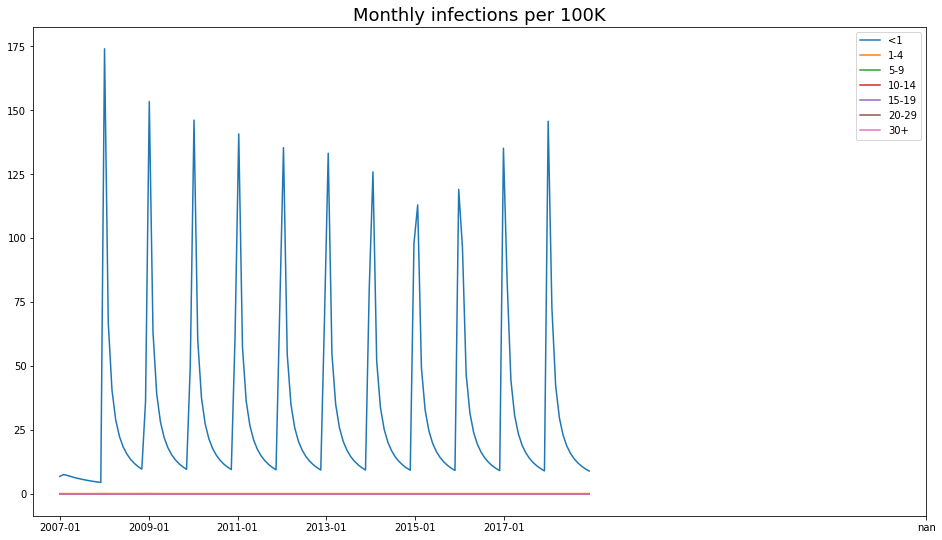

In [19]:
beta = np.array([0.08,0.15,0.2,0.3,0.2,0.2,0.2])

print((beta@para.C/365)@np.ones(7))


mdl = m.SIRVModel(para, lambda t: beta)
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)

eval_year = 120
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.00001, method="RK45", eval_per_year=eval_year, pop_scale=pop_scale, 
                         atol=1e-6, rtol = 1e-4)
"""""
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t[0:len(t)], np.transpose(out[7+ii,0:len(t)]), label = age_class[ii])
plt.legend()
plt.title("Infected curve for all age groups (unnormalized)", fontsize = 18)
"""

plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)


Text(0.5, 1.0, 'Monthly infections per 100K')

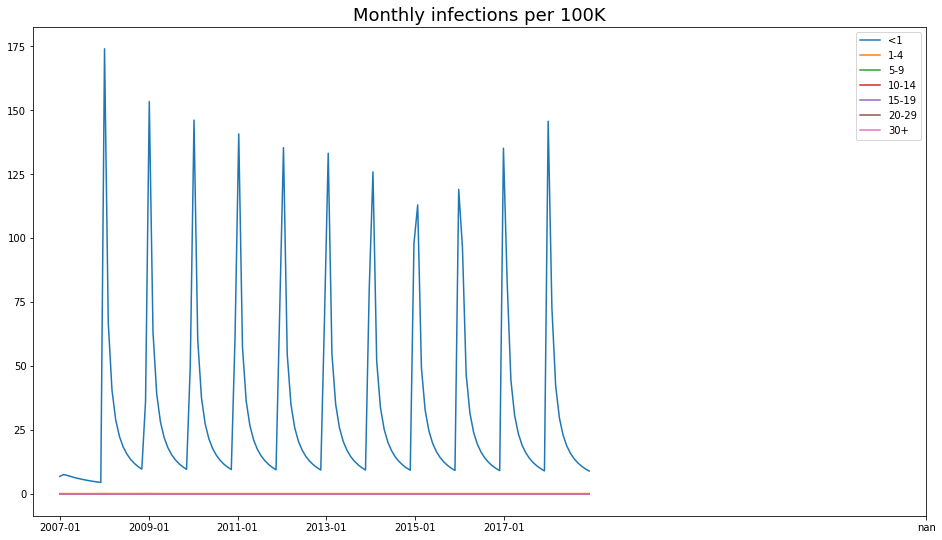

In [20]:
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)


NameError: name 'My_Time' is not defined

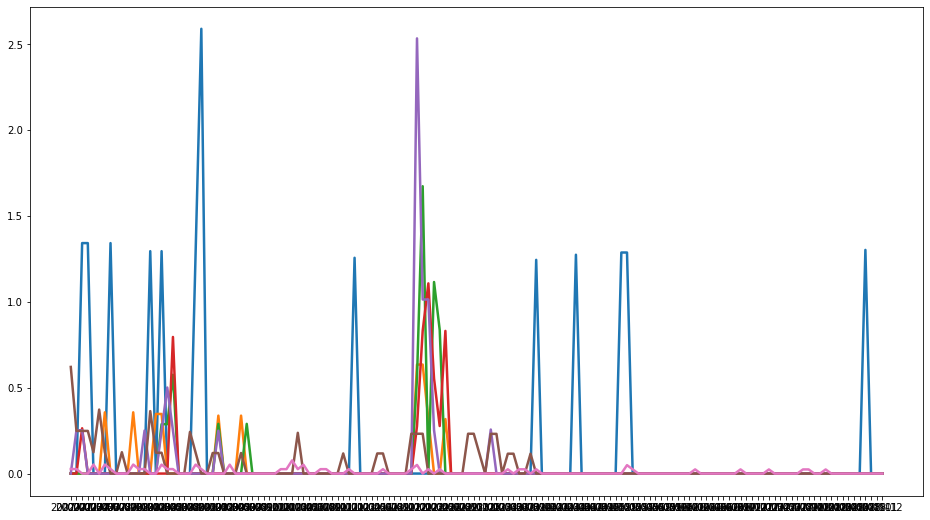

In [21]:
for d in ['Rubella']:
#for d in ['Measles']:
    #option for dotted in Mumps
    if d == "Mumps":
        fig = plt.figure(figsize=(16,9))
        for cc in age_class:
            plt.plot(time_date, monthly_data[cc], "-o", markersize = 7, lw = 2.5, label= cc)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
    else:
        fig = plt.figure(figsize=(16,9))
        for cc in age_class:
            plt.plot(time_date, monthly_data[cc], lw = 2.5, label= cc)
        step_loc = math.floor(len(My_Time)/8)
        locs = np.arange(0, 9) * step_loc

        plt.yticks(fontsize = 18)
        plt.xticks(locs, My_Time.loc[locs][0], fontsize = 18)
            
    plt.xlabel("Time", fontsize=18)
    plt.legend(shadow= True, fontsize = 19)
    plt.title(d+" Cases Per 100k", fontsize = 20)
    #svg better for Poster
    
    #plt.savefig(d+"Plot.svg")
    #plt.figure(figsize=(16,9))
    for ii in range(7):
        plt.plot(time_date[0:len(time_date)-1], 
                 (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])
    plt.legend()
    #plt.title("Monthly infections per 100K", fontsize = 18)


## Plotting the scaled infected by normalising pop

In [ ]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    tot = np.sum(out[np.array([0,7,14,21])+ii,], axis=0)
    plt.plot(t[0:len(t)], (np.transpose(out[7+ii,]) / tot)[0:len(t)]*100, label = age_class[ii])
plt.legend()
if d == "Mumps":
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date)
else:
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date[np.arange(1, years_run)*12])

plt.title("Infected curve for all age groups (normalized per 100k)", fontsize = 18)

if d == "Mumps":
    plt.savefig("Inf_sim_"+d+"_noOpt.svg")

In [22]:
fit_Rubella = scipy.optimize.fmin(f_ssq_timeout, x0 = np.array([0.08,0.15,0.2,0.3,0.2,0.2,0.2]), xtol=1e-4
                                  ,maxiter = 2000, maxfun = 2000, full_output=1)

Loss: 73949.1544899806 Beta: [0.08 0.15 0.2  0.3  0.2  0.2  0.2 ]
Loss: 73046.861137451 Beta: [0.084 0.15  0.2   0.3   0.2   0.2   0.2  ]
Loss: 72790.6042510313 Beta: [0.08   0.1575 0.2    0.3    0.2    0.2    0.2   ]
Loss: 73949.59691901179 Beta: [0.08 0.15 0.21 0.3  0.2  0.2  0.2 ]
Loss: 73949.52520226275 Beta: [0.08  0.15  0.2   0.315 0.2   0.2   0.2  ]
Loss: 73972.02158117286 Beta: [0.08 0.15 0.2  0.3  0.21 0.2  0.2 ]
Loss: 74011.40169678842 Beta: [0.08 0.15 0.2  0.3  0.2  0.21 0.2 ]
Loss: 73978.30629992565 Beta: [0.08 0.15 0.2  0.3  0.2  0.2  0.21]
Loss: 73766.87767554812 Beta: [0.08114286 0.15214286 0.20285714 0.30428571 0.20285714 0.19
 0.20285714]
Loss: 73592.42422289509 Beta: [0.08146939 0.1527551  0.20367347 0.3055102  0.20367347 0.19714286
 0.19081633]
Loss: 73344.66246246755 Beta: [0.08188921 0.15354227 0.20472303 0.30708455 0.19186589 0.19632653
 0.19819242]
Loss: 72912.24485887392 Beta: [0.08242899 0.15455435 0.19321533 0.3091087  0.19954186 0.19527697
 0.19767597]
Loss: 

 0.20864317]
Loss: 55496.18487110329 Beta: [0.09006528 0.19044122 0.1883353  0.24295475 0.17611097 0.18777865
 0.20898342]
Loss: 55924.13430122608 Beta: [0.09089543 0.18525396 0.19300683 0.24239744 0.17758629 0.18724741
 0.20867039]
Loss: 55753.45097430461 Beta: [0.08997843 0.18247109 0.19015103 0.25317053 0.1817201  0.18917317
 0.20829385]
Loss: 55456.02878084381 Beta: [0.08933451 0.18940651 0.18810787 0.24697646 0.17594925 0.18780662
 0.21097305]
Loss: 55353.270960730646 Beta: [0.0885244  0.19484984 0.18555134 0.24426364 0.17189133 0.18709118
 0.21325695]
Loss: 55310.062136498665 Beta: [0.08967477 0.19305544 0.18729241 0.24402882 0.17413159 0.18627091
 0.21188886]
Loss: 55265.21275613781 Beta: [0.08943715 0.19992782 0.18486321 0.23960016 0.16981062 0.18442887
 0.21422551]
Loss: 55227.45498703965 Beta: [0.08862647 0.19618316 0.18759395 0.2406257  0.17332121 0.18483482
 0.21015092]
Loss: 55118.96834959519 Beta: [0.08753624 0.20354494 0.18624251 0.23464826 0.16972022 0.18233026
 0.21016

  0.28695257]
Loss: 41723.608781559655 Beta: [ 6.66633398e-02  4.62714909e-01  1.04620568e-01  1.53210399e-02
 -2.23881842e-04  1.41821244e-01  2.86532020e-01]
Loss: 41472.327272125345 Beta: [ 0.06645034  0.46451734  0.1038865   0.0134275  -0.00137376  0.14184573
  0.28709444]
Loss: 41763.22542220195 Beta: [0.06668965 0.46161198 0.10517916 0.01607171 0.00056888 0.14179258
 0.28584825]
Loss: 41818.16916285145 Beta: [0.06673366 0.46119725 0.10519484 0.01658629 0.00083178 0.1418878
 0.28577369]
Loss: 35058.527620903624 Beta: [0.06693482 0.4595017  0.10550877 0.01830541 0.00174178 0.14234203
 0.28558968]
Loss: 36926.21148464609 Beta: [0.06691077 0.45839074 0.106056   0.01937524 0.00261763 0.14227231
 0.2848019 ]
Loss: 38113.44659702468 Beta: [0.06703755 0.4573953  0.10639293 0.01983037 0.00319305 0.14267623
 0.28475864]
Loss: 41663.55612069101 Beta: [ 6.66276582e-02  4.62614140e-01  1.04629422e-01  1.57242416e-02
 -1.04671013e-04  1.41823542e-01  2.86222669e-01]
Loss: 41745.779260777155 Be

 0.28554388]
Loss: 35013.82730651637 Beta: [0.06689237 0.45948741 0.10551934 0.01837857 0.00178439 0.14244708
 0.28551708]
Loss: 34920.369133422246 Beta: [0.06688586 0.459549   0.10550136 0.01831235 0.00174519 0.14244246
 0.28553718]
Loss: 34893.72635802354 Beta: [0.06688075 0.45955155 0.10550755 0.01831023 0.00175696 0.14242489
 0.28550927]
Loss: 34975.97277789474 Beta: [0.06688074 0.45952148 0.10551745 0.01833601 0.00176524 0.14246325
 0.28551681]
Loss: 34922.06393398843 Beta: [0.06688802 0.4595403  0.10550327 0.01832386 0.00175385 0.14243172
 0.28552962]
Loss: 34996.25530936996 Beta: [0.06688316 0.45952775 0.10551272 0.01833196 0.00176144 0.14245274
 0.28552108]
Loss: 34940.57973425357 Beta: [0.06688681 0.45953716 0.10550563 0.01832589 0.00175574 0.14243698
 0.28552748]
Loss: 34927.89806590034 Beta: [0.06688343 0.45954604 0.10550539 0.01831781 0.00175476 0.1424325
 0.28551929]
Loss: 34909.0458579326 Beta: [0.06688495 0.45954779 0.10549964 0.01832334 0.00175179 0.14243569
 0.28552734

 0.28552655]
Loss: 34894.33717425954 Beta: [0.06688533 0.45954041 0.10550539 0.01832387 0.00175375 0.14243966
 0.28552647]
Loss: 34894.33813040589 Beta: [0.06688535 0.45954043 0.10550536 0.01832386 0.00175374 0.14243958
 0.28552649]
Loss: 34885.58866186369 Beta: [0.06688537 0.45954029 0.10550546 0.01832394 0.00175378 0.14243961
 0.28552648]
Loss: 34894.26316230942 Beta: [0.06688535 0.45954041 0.10550542 0.01832383 0.00175375 0.14243953
 0.28552645]
Loss: 34894.338829131855 Beta: [0.06688537 0.45954037 0.10550541 0.01832389 0.00175373 0.1424396
 0.28552652]
Loss: 34894.391966537354 Beta: [0.06688535 0.45954042 0.10550538 0.0183239  0.00175375 0.14243956
 0.28552649]
Loss: 34894.45315390921 Beta: [0.06688537 0.45954033 0.10550544 0.01832387 0.00175372 0.14243966
 0.28552657]
Loss: 34894.47826463362 Beta: [0.06688537 0.45954036 0.10550543 0.01832386 0.00175374 0.14243961
 0.28552653]
Loss: 34894.50025119309 Beta: [0.06688538 0.45954036 0.10550541 0.01832388 0.00175374 0.14243954
 0.285526

 0.28552645]
Loss: 34894.450146173054 Beta: [0.06688533 0.45954035 0.10550548 0.01832393 0.00175377 0.14243968
 0.28552644]
Loss: 34884.56978396873 Beta: [0.06688533 0.45954033 0.1055055  0.01832393 0.00175377 0.1424397
 0.28552644]
Loss: 34894.45008654864 Beta: [0.06688533 0.45954034 0.10550549 0.01832393 0.00175377 0.14243969
 0.28552644]
Loss: 34884.56681156771 Beta: [0.06688533 0.45954033 0.10550549 0.01832393 0.00175377 0.14243969
 0.28552644]
Loss: 34884.541490647425 Beta: [0.06688532 0.45954031 0.10550553 0.01832392 0.00175377 0.14243973
 0.28552643]
Loss: 34894.44275918453 Beta: [0.06688532 0.45954032 0.10550552 0.01832393 0.00175377 0.14243972
 0.28552643]
Loss: 34884.562481382236 Beta: [0.06688533 0.45954033 0.1055055  0.01832393 0.00175377 0.1424397
 0.28552644]
Loss: 34894.4446975614 Beta: [0.06688533 0.45954033 0.10550551 0.01832393 0.00175377 0.1424397
 0.28552643]
Loss: 34884.56081589451 Beta: [0.06688533 0.45954033 0.1055055  0.01832393 0.00175377 0.1424397
 0.28552644]

 0.28552078]
Loss: 34878.848483790294 Beta: [0.06688154 0.45953403 0.10551864 0.01832632 0.00175596 0.14245572
 0.28551925]
Loss: 34879.34791204836 Beta: [0.06688186 0.45953452 0.10551756 0.01832611 0.00175578 0.14245434
 0.28551985]
Loss: 34878.644801681265 Beta: [0.06688136 0.45953374 0.10551925 0.01832645 0.00175607 0.14245637
 0.28551888]
Loss: 34876.73116118194 Beta: [0.06688016 0.45953175 0.10552342 0.01832721 0.00175678 0.14246141
 0.28551657]
Loss: 34877.72573559667 Beta: [0.06688075 0.4595327  0.10552139 0.01832684 0.00175642 0.14245901
 0.28551773]
Loss: 34876.88979698083 Beta: [0.06688021 0.45953179 0.10552327 0.01832714 0.00175673 0.14246133
 0.28551673]
Loss: 34876.378459995394 Beta: [0.0668799  0.45953127 0.10552434 0.01832731 0.0017569  0.14246264
 0.28551615]
Loss: 34884.2284852656 Beta: [0.06687845 0.45952882 0.10552942 0.01832819 0.00175774 0.14246885
 0.2855134 ]
Loss: 34875.66222569385 Beta: [0.06687944 0.45953052 0.10552594 0.01832761 0.00175718 0.14246458
 0.28551

 0.2855099 ]
Loss: 34872.48286508041 Beta: [0.06687739 0.45952704 0.10553308 0.01832887 0.00175835 0.14247334
 0.28551142]
Loss: 34871.25187938594 Beta: [0.06687656 0.45952563 0.10553596 0.01832936 0.00175881 0.14247698
 0.28550992]
Loss: 34881.44490088745 Beta: [0.06687648 0.45952549 0.10553624 0.01832942 0.00175885 0.14247734
 0.28550978]
Loss: 34872.19407059053 Beta: [0.0668772  0.4595267  0.10553376 0.01832898 0.00175846 0.14247421
 0.28551107]
Loss: 34871.10349433647 Beta: [0.06687647 0.45952546 0.1055363  0.01832941 0.00175886 0.1424774
 0.28550975]
Loss: 34870.97066938466 Beta: [0.06687638 0.45952528 0.10553665 0.01832945 0.00175891 0.14247784
 0.28550959]
Loss: 34880.89245358408 Beta: [0.06687593 0.4595245  0.10553821 0.01832969 0.00175915 0.14247982
 0.28550879]
Loss: 34870.82324848092 Beta: [0.06687612 0.45952486 0.1055375  0.01832961 0.00175904 0.14247897
 0.28550915]
Loss: 34869.995561017415 Beta: [0.06687556 0.45952389 0.10553947 0.01832993 0.00175934 0.1424815
 0.28550815

 0.2855045 ]
Loss: 34877.42696583652 Beta: [0.06687336 0.45952018 0.10554704 0.01833119 0.00176052 0.14249133
 0.28550429]
Loss: 34867.535736574326 Beta: [0.06687385 0.45952101 0.10554535 0.01833092 0.00176026 0.14248912
 0.28550514]
Loss: 34866.81589872632 Beta: [0.06687334 0.45952017 0.10554708 0.0183312  0.00176053 0.14249139
 0.28550427]
Loss: 34866.629874522296 Beta: [0.06687322 0.45951998 0.1055475  0.0183313  0.0017606  0.1424919
 0.28550404]
Loss: 34876.75044672763 Beta: [0.06687286 0.4595194  0.10554872 0.01833153 0.00176079 0.14249348
 0.2855034 ]
Loss: 34877.12270460751 Beta: [0.06687313 0.45951982 0.10554781 0.01833133 0.00176064 0.14249232
 0.28550389]
Loss: 34867.27909060873 Beta: [0.06687367 0.45952072 0.10554597 0.01833102 0.00176036 0.14248992
 0.28550483]
Loss: 34866.69833071377 Beta: [0.06687326 0.45952004 0.10554736 0.01833126 0.00176057 0.14249174
 0.28550412]
Loss: 34866.53397684977 Beta: [0.06687314 0.45951983 0.10554778 0.01833132 0.00176063 0.1424923
 0.2855039

 0.28550093]
Loss: 34863.876813525036 Beta: [0.06687128 0.45951664 0.10555421 0.01833234 0.0017616  0.14250082
 0.28550075]
Loss: 34863.53224541598 Beta: [0.06687103 0.4595162  0.10555507 0.01833246 0.00176173 0.14250198
 0.28550034]
Loss: 34863.82375511675 Beta: [0.06687124 0.45951657 0.10555435 0.01833235 0.00176162 0.14250102
 0.28550069]
Loss: 34874.52086668415 Beta: [0.06687117 0.45951646 0.10555459 0.0183324  0.00176166 0.14250132
 0.28550056]
Loss: 34864.22084252575 Beta: [0.06687149 0.45951702 0.10555345 0.01833223 0.00176149 0.1424998
 0.28550111]
Loss: 34874.515489050085 Beta: [0.06687116 0.45951645 0.1055546  0.01833241 0.00176166 0.14250134
 0.28550055]
Loss: 34864.19706425351 Beta: [0.06687148 0.45951699 0.10555351 0.01833224 0.0017615  0.14249988
 0.28550108]
Loss: 34863.72604696382 Beta: [0.06687117 0.45951645 0.10555458 0.01833239 0.00176165 0.14250132
 0.28550058]
Loss: 34863.578434161514 Beta: [0.06687106 0.45951625 0.10555497 0.01833243 0.00176171 0.14250186
 0.28550

 0.28549856]
Loss: 34872.81336261062 Beta: [0.06686987 0.45951409 0.10555917 0.01833295 0.00176229 0.14250758
 0.28549848]
Loss: 34862.17664810134 Beta: [0.06687009 0.4595145  0.10555838 0.01833286 0.00176218 0.1425065
 0.28549883]
Loss: 34861.90660922659 Beta: [0.06686989 0.45951413 0.10555909 0.01833294 0.00176228 0.14250747
 0.28549851]
Loss: 34861.82270335518 Beta: [0.06686983 0.45951401 0.10555931 0.01833297 0.00176231 0.14250777
 0.28549841]
Loss: 34861.654519269105 Beta: [0.06686968 0.45951374 0.10555984 0.01833303 0.00176239 0.1425085
 0.28549817]
Loss: 34861.71146314907 Beta: [0.06686975 0.45951386 0.10555961 0.018333   0.00176235 0.14250817
 0.28549828]
Loss: 34872.597972365125 Beta: [0.0668697  0.45951377 0.10555979 0.01833302 0.00176238 0.14250842
 0.2854982 ]
Loss: 34862.00584857798 Beta: [0.06686997 0.45951426 0.10555883 0.01833291 0.00176225 0.14250711
 0.28549863]
Loss: 34872.588916438894 Beta: [0.06686969 0.45951376 0.10555981 0.01833303 0.00176238 0.14250845
 0.285498

 0.28549752]
Loss: 34861.25944541892 Beta: [0.06686938 0.45951319 0.1055609  0.01833314 0.00176253 0.14250996
 0.2854977 ]
Loss: 34861.1112067514 Beta: [0.06686927 0.45951297 0.10556131 0.01833318 0.00176258 0.14251052
 0.28549753]
Loss: 34871.99435302123 Beta: [0.0668692  0.45951284 0.10556155 0.0183332  0.00176261 0.14251087
 0.28549742]
Loss: 34872.06158983355 Beta: [0.06686926 0.45951295 0.10556135 0.01833318 0.00176259 0.14251059
 0.28549751]
Loss: 34861.223058524934 Beta: [0.06686936 0.45951313 0.105561   0.01833315 0.00176254 0.1425101
 0.28549766]
Loss: 34872.05827448522 Beta: [0.06686926 0.45951294 0.10556136 0.01833318 0.00176259 0.1425106
 0.28549751]
Loss: 34861.217059123934 Beta: [0.06686935 0.45951312 0.10556102 0.01833315 0.00176254 0.14251012
 0.28549766]
Loss: 34861.12453716733 Beta: [0.06686928 0.45951299 0.10556127 0.01833317 0.00176258 0.14251047
 0.28549755]
Loss: 34872.069436743535 Beta: [0.06686927 0.45951296 0.10556133 0.01833318 0.00176258 0.14251057
 0.2854975

 0.28549703]
Loss: 34860.740638031115 Beta: [0.06686899 0.45951245 0.10556231 0.01833328 0.00176271 0.14251191
 0.28549709]
Loss: 34860.68499376088 Beta: [0.06686895 0.45951237 0.10556246 0.0183333  0.00176273 0.14251212
 0.28549703]
Loss: 34860.648834416 Beta: [0.06686892 0.45951232 0.10556256 0.0183333  0.00176275 0.14251226
 0.28549698]
Loss: 34860.67342846414 Beta: [0.06686894 0.45951235 0.10556249 0.0183333  0.00176274 0.14251217
 0.28549701]
Loss: 34860.65577002742 Beta: [0.06686893 0.45951232 0.10556254 0.0183333  0.00176274 0.14251223
 0.28549699]
Loss: 34860.63432349679 Beta: [0.06686891 0.45951229 0.1055626  0.01833331 0.00176275 0.14251231
 0.28549697]
Loss: 34871.59132903719 Beta: [0.06686887 0.45951222 0.10556274 0.01833332 0.00176277 0.14251251
 0.28549691]
Loss: 34860.63411942971 Beta: [0.06686891 0.45951229 0.1055626  0.01833331 0.00176275 0.14251232
 0.28549697]
Loss: 34860.59342550692 Beta: [0.06686888 0.45951223 0.10556271 0.01833332 0.00176277 0.14251247
 0.28549692

 0.2854967 ]
Loss: 34860.358061792045 Beta: [0.0668687  0.45951189 0.10556335 0.01833338 0.00176285 0.14251337
 0.28549664]
Loss: 34871.35535063641 Beta: [0.06686868 0.45951185 0.10556344 0.01833339 0.00176286 0.14251349
 0.2854966 ]
Loss: 34871.36918411255 Beta: [0.06686869 0.45951187 0.1055634  0.01833338 0.00176286 0.14251343
 0.28549662]
Loss: 34860.40196850381 Beta: [0.06686874 0.45951196 0.10556323 0.01833337 0.00176283 0.1425132
 0.28549669]
Loss: 34871.37961421675 Beta: [0.0668687  0.45951188 0.10556337 0.01833338 0.00176285 0.14251339
 0.28549664]
Loss: 34860.394769728664 Beta: [0.06686873 0.45951195 0.10556325 0.01833337 0.00176284 0.14251323
 0.28549669]
Loss: 34871.38425008884 Beta: [0.0668687  0.45951189 0.10556335 0.01833338 0.00176285 0.14251337
 0.28549664]
Loss: 34860.39070307521 Beta: [0.06686873 0.45951194 0.10556326 0.01833337 0.00176284 0.14251324
 0.28549668]
Loss: 34860.35859439723 Beta: [0.0668687  0.45951189 0.10556335 0.01833338 0.00176285 0.14251337
 0.285496

 0.28549649]
Loss: 34860.24911499914 Beta: [0.06686862 0.45951173 0.10556365 0.0183334  0.00176289 0.14251379
 0.28549652]
Loss: 34860.22833316256 Beta: [0.0668686  0.4595117  0.10556371 0.01833341 0.0017629  0.14251387
 0.28549649]
Loss: 34860.214916967205 Beta: [0.06686859 0.45951168 0.10556375 0.01833341 0.0017629  0.14251392
 0.28549648]
Loss: 34860.22044738861 Beta: [0.0668686  0.45951169 0.10556373 0.01833341 0.0017629  0.1425139
 0.28549648]
Loss: 34871.252140895405 Beta: [0.06686859 0.45951168 0.10556375 0.01833341 0.0017629  0.14251393
 0.28549647]
Loss: 34860.241521440825 Beta: [0.06686861 0.45951172 0.10556367 0.01833341 0.00176289 0.14251382
 0.28549651]
Loss: 34871.25188709573 Beta: [0.06686859 0.45951168 0.10556375 0.01833341 0.0017629  0.14251393
 0.28549647]
Loss: 34860.24003272553 Beta: [0.06686861 0.45951172 0.10556368 0.01833341 0.00176289 0.14251382
 0.2854965 ]
Loss: 34860.21995236457 Beta: [0.0668686  0.45951169 0.10556373 0.01833341 0.0017629  0.1425139
 0.285496

 0.2854964 ]
Loss: 34871.19676861019 Beta: [0.06686854 0.45951159 0.10556392 0.01833343 0.00176292 0.14251416
 0.2854964 ]
Loss: 34860.16392368069 Beta: [0.06686855 0.45951161 0.10556389 0.01833342 0.00176292 0.14251412
 0.28549642]
Loss: 34871.19721575585 Beta: [0.06686855 0.45951159 0.10556392 0.01833343 0.00176292 0.14251416
 0.2854964 ]
Loss: 34860.16314083948 Beta: [0.06686855 0.45951161 0.10556389 0.01833342 0.00176292 0.14251412
 0.28549641]
Loss: 34860.153907644504 Beta: [0.06686855 0.45951159 0.10556392 0.01833343 0.00176292 0.14251416
 0.2854964 ]
Loss: 34860.148266525575 Beta: [0.06686854 0.45951158 0.10556393 0.01833343 0.00176292 0.14251418
 0.2854964 ]
Loss: 34860.15069982266 Beta: [0.06686854 0.45951159 0.10556392 0.01833343 0.00176292 0.14251417
 0.2854964 ]
Loss: 34871.19233764617 Beta: [0.06686854 0.45951158 0.10556393 0.01833343 0.00176293 0.14251418
 0.2854964 ]
Loss: 34860.159337631754 Beta: [0.06686855 0.4595116  0.1055639  0.01833342 0.00176292 0.14251414
 0.2854

 0.28549636]
Loss: 34860.10599506468 Beta: [0.06686851 0.45951152 0.10556405 0.01833344 0.00176294 0.14251435
 0.28549635]
Loss: 34860.10146780215 Beta: [0.06686851 0.45951151 0.10556406 0.01833344 0.00176294 0.14251436
 0.28549634]
Loss: 34860.10302961558 Beta: [0.06686851 0.45951152 0.10556406 0.01833344 0.00176294 0.14251436
 0.28549634]
Loss: 34871.149607242005 Beta: [0.06686851 0.45951151 0.10556406 0.01833344 0.00176294 0.14251436
 0.28549634]
Loss: 34860.11017549599 Beta: [0.06686851 0.45951153 0.10556404 0.01833343 0.00176294 0.14251433
 0.28549635]
Loss: 34871.151922181714 Beta: [0.06686851 0.45951152 0.10556405 0.01833344 0.00176294 0.14251436
 0.28549635]
Loss: 34860.108846512216 Beta: [0.06686851 0.45951153 0.10556404 0.01833344 0.00176294 0.14251434
 0.28549635]
Loss: 34871.1518595802 Beta: [0.06686851 0.45951152 0.10556406 0.01833344 0.00176294 0.14251436
 0.28549635]
Loss: 34860.10859449953 Beta: [0.06686851 0.45951153 0.10556404 0.01833344 0.00176294 0.14251434
 0.28549

 0.28549633]
Loss: 34860.08689903343 Beta: [0.06686849 0.45951149 0.1055641  0.01833344 0.00176295 0.14251442
 0.28549633]
Loss: 34871.13565187809 Beta: [0.06686849 0.45951149 0.10556411 0.01833344 0.00176295 0.14251443
 0.28549632]
Loss: 34860.08951344338 Beta: [0.0668685  0.4595115  0.1055641  0.01833344 0.00176295 0.14251441
 0.28549633]
Loss: 34860.08616261598 Beta: [0.06686849 0.45951149 0.10556411 0.01833344 0.00176295 0.14251443
 0.28549632]
Loss: 34860.08586985794 Beta: [0.06686849 0.45951149 0.10556411 0.01833344 0.00176295 0.14251443
 0.28549632]
Loss: 34860.084992692384 Beta: [0.06686849 0.45951149 0.10556411 0.01833344 0.00176295 0.14251443
 0.28549632]
Loss: 34871.13249250565 Beta: [0.06686849 0.45951149 0.10556411 0.01833344 0.00176295 0.14251444
 0.28549632]
Loss: 34860.08469387632 Beta: [0.06686849 0.45951149 0.10556411 0.01833344 0.00176295 0.14251443
 0.28549632]
Loss: 34871.13243466581 Beta: [0.06686849 0.45951149 0.10556411 0.01833344 0.00176295 0.14251444
 0.285496

 0.28549631]
Loss: 34871.1275657055 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.1278456915 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07753082051 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07771016552 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127972559734 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549632]
Loss: 34860.07753363489 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12719322587 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12799570926 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549632]
Loss: 34871.12766801009 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631

 0.28549631]
Loss: 34860.07731143571 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127519045796 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12752291445 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12752000054 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12751776542 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07731238962 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12752312246 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12752557367 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12751532861 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.285496

 0.28549631]
Loss: 34871.12748934929 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748914623 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748927721 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127489605584 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127489648934 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12749024505 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12749028697 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.077279988225 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.077280107325 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.285

 0.28549631]
Loss: 34871.1274879992 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07727878428 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748804013 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127488006474 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748801982 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748800928 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07727874314 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748800992 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.1274880134 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631

 0.28549631]
Loss: 34871.1274880092 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748802111 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127488012775 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748799428 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748801137 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07727866979 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127487999234 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798107 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748801513 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.285496

 0.28549631]
Loss: 34871.12748799355 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748800289 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.1274880095 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07727868657 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.1274880154 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748801769 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127488014376 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.1274880141 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748802706 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]

 0.28549631]
Loss: 34871.127487999336 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127487999336 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127488011436 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127487999336 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127488011436 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127487999336 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127488011436 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127487999336 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748801143 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0

 0.28549631]
Loss: 34871.12748801505 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798956 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34860.07727873283 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798583 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798583 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798583 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748801505 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798956 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798583 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.2854963

 0.28549631]
Loss: 34871.12748802799 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127487994454 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748802799 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.127487994454 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798956 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798583 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798583 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748798583 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549631]
Loss: 34871.12748801505 Beta: [0.06686849 0.45951148 0.10556413 0.01833344 0.00176295 0.14251446
 0.28549

Text(0.5, 1.0, 'Monthly infections per 100K')

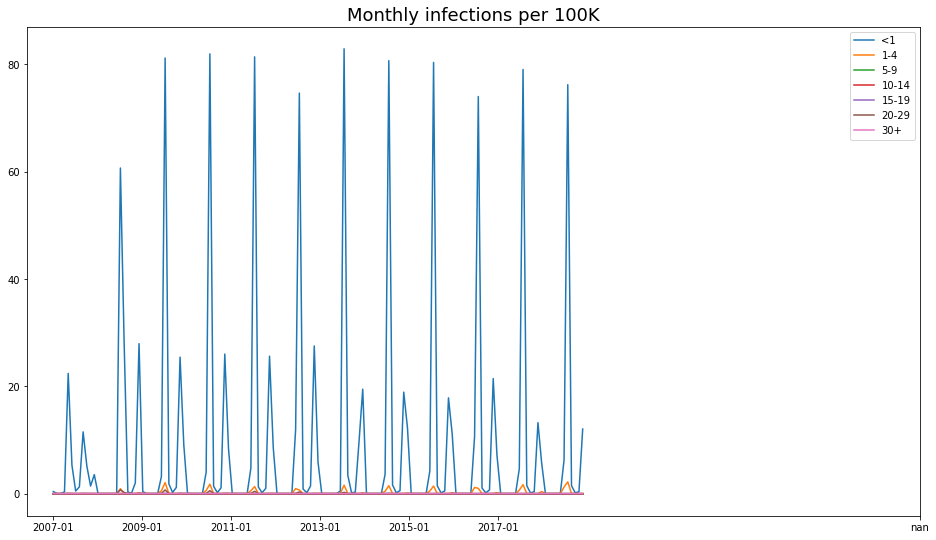

In [24]:
beta = np.eye(7)*np.maximum(fit_Rubella[0],0.001)

mdl = m.SIRVModel(para, lambda t: beta)
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)

eval_year = 120
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=120, atol =1e-6, rtol = 1e-3)

plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

locs, labels = plt.xticks()
locs = np.hstack([locs[1:-2], 19.5])
plt.xticks(locs, time_date[locs*12])
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)

In [25]:
np.maximum(fit_Rubella[0],0.001)

array([0.06686849, 0.45951148, 0.10556413, 0.01833344, 0.00176295,
       0.14251446, 0.28549631])

In [ ]:
n_eval=120
beta = np.eye(7)*np.maximum(fit_Rubella[0],0.001)
mdl = m.SIRVModel(para, lambda t: beta)  
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)   

In [ ]:
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, atol =1e-6, rtol = 1e-3)

In [ ]:
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.linspace(0,years_run, years_run*12)[0:-1], 
             (1e5/pop_scale)*np.transpose(get_monthly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])